In [14]:
import sys
sys.path.append('/home/axf295/2019/code/spt3g_software/build/')
sys.path.append('/home/axf295/2019/code/spt3g_software/polcal/python/')
from spt3g import core

import CenA_Map_Utils as CMU
import General_Utils  as GU
import os
import pickle as pk
import numpy as np








def calc_source_masked_variance(bolo_map,Noise_Mask=''):

    '''
    Calculate the variance of a masked map
    Checks the shapes of both maps and does the right thing.
    
    Arguments
    ---------
    bolo_map : 2D numpy array
        map to be masked and to of which to find the variance
        
    noise_mask : 2D numpy array
        mask map; multiplies bolo_map to mask source.
    
    Returns
    -------
    variance: float
        variance of the masked map (where bolo_map*noise_mask !=0)
        
    '''

    if Noise_Mask == '':
        Noise_Mask = np.zeros(np.shape(bolo_map))
        Noise_Mask[np.where(abs(bolo_map)>1.)]+=1.
        Noise_Mask = 1.- Noise_Mask
    plt.imshow(Noise_Mask)
    plt.show()
    ms = np.shape(Noise_Mask)[0]
    dsx = np.shape(bolo_map)[0]
    dsy = np.shape(bolo_map)[1]
    if dsx > ms or dsy > ms:
        bolo_map = bolo_map[dsx//2-ms//2:dsx//2+ms//2, dsy//2-ms//2:dsy//2+ms//2]
        bolonoisemask = Noise_Mask
    elif dsx < ms or dsy < ms:
        bolonoisemask = Noise_Mask[ms//2-dsx//2:ms//2+dsx//2, ms//2-dsy//2:ms//2+dsy//2]
    else:
        bolonoisemask = Noise_Mask
    try:
        plt.imshow(bolo_map*bolonoisemask)
        plt.show()
        variance = np.nanvar(bolo_map[np.nonzero(bolonoisemask)])
    except IndexError:
        variance = -1
    return variance







## Static data locations
singlebolomap_loc = '/spt/user/production/calibration/CenA-pixelraster/singlebolomaps/'
coaddmap_loc      = '/spt/user/production/calibration/CenA-pixelraster/coaddmaps/'
calframe_loc = '/spt/user/production/calibration/boloproperties/60000000.g3'

analyzed_data_dir = '/big_scratch/axf295/2019/CenA/Analyzed_Data/'



## Load all observations
obsids = GU.get_cena_obsids(season='winter',years=[2019])
failed_obs = {}

## Get latest BoloProperties
boloprops = {}    
for frame in core.G3File(calframe_loc):
    for bolo in frame['BolometerProperties'].keys():
        boloprops[bolo] =  frame['BolometerProperties'][bolo]

## Make Dictionaries for IV-weighted coadds and their weight sums
coadd_map_coadds = {}
single_bolo_coadd_maps = {}
for obs in obsids:
    print(obs)
    print('Attempting to load data from %s\n'%obs)
    
    ## Make sure data_dir exists
    data_dir = analyzed_data_dir+'%s/'%obs
    if not os.path.exists(data_dir):
        failed_obs[obs] = 'Data path, %s doesn\'t exist'%data_dir
        continue
        
    ## Load the good bolos (as definined in Fit_CenA_Polarization)
    goodbololist = data_dir+'%s_GoodBolos.pkl'%obs
    if os.path.exists(goodbololist):
        good_bolos = pk.load(open(goodbololist,'rb'))
    else:
        print('Couldnt load %s'%(goodbololist))
        failed_obs[obs] = 'Couldnt load %s'%goodbololist
        continue
    
    ## Load the bolo map variance
    mapvarfile = data_dir + 'Bolo_Noise_Dictionary.pkl'
    if os.path.exists(mapvarfile):
        bolo_map_noise = pk.load(open(mapvarfile,'rb'))
    else:
        print('Couldnt load %s'%(mapvarfile))
        failed_obs[obs] = 'Couldnt load %s'%mapvarfile
        continue         
        
    ## Load the SN calculated in a previous script
    ## Load the center locations
    try:
        center_locs = pk.load(open(data_dir+'CenA_center_location_Dictionary.pkl','rb'))
    except Exception:
        print('Couldnt load %s'%(data_dir+'CenA_center_location_Dictionary.pkl'))
        failed_obs[obs] = 'Couldnt load %s'%(data_dir+'CenA_center_location_Dictionary.pkl')
        continue
    ## Set the center location of the source.    
    xo = int(np.nanmedian(center_locs['x']))
    yo = int(np.nanmedian(center_locs['y']))
    
    ## Load autoprocessed TQU maps ; per band coadds only
    coaddfile = coaddmap_loc+'%s.g3'%obs
    if os.path.exists(coaddfile):
        template_tqu_maps = CMU.load_perband_coaddmaps(coaddfile,xo=xo,yo=yo)
    else:
        print('Couldnt load %s'%coaddfile)
        failed_obs[obs] = 'Couldnt load %s'%(coaddfile)
        continue
   
            
    print('Coadd Maps Loaded!\n')
    
    
    ## Coadd tqu coadds by IV weighting
    for band in template_tqu_maps:
        map_var = np.var(template_tqu_maps[band].maps['T'][60:,:20])#calc_source_masked_variance(template_tqu_maps[band].maps['T'])
        print(map_var)
        if band not in coadd_map_coadds:
            coadd_map_coadds[band] = template_tqu_maps[band]
            for mt in ['T','Q','U']:
                coadd_map_coadds[band].maps[mt]/=np.copy(map_var)
            coadd_map_coadds[band].noise  = np.copy(1./map_var)
            coadd_map_coadds[band].numobs = 1
            
        else:
            for mt in ['T','Q','U']:
                coadd_map_coadds[band].maps[mt]+=np.copy(template_tqu_maps[band].maps[mt]/map_var)
            coadd_map_coadds[band].noise  += np.copy(1./map_var)
            coadd_map_coadds[band].numobs += 1
    
    
for band in coadd_map_coadds:
    for mt in coadd_map_coadds[band].maps:
        coadd_map_coadds[band].maps[mt]/=coadd_map_coadds[band].noise
    print(CMU.calc_source_masked_variance(coadd_map_coadds[band].maps['T']))
    

        


    
    

76069964
Attempting to load data from 76069964

Coadd Maps Loaded!

0.00536203684344
0.00215564525648
0.0388920947335
72096094
Attempting to load data from 72096094

Coadd Maps Loaded!

0.00502452208756
0.00207978819228
0.0353579025254
73240056
Attempting to load data from 73240056

Coadd Maps Loaded!

0.00378719566485
0.00203146339738
0.0317057843504
74915420
Attempting to load data from 74915420

Coadd Maps Loaded!

0.0047766528799
0.00257702735864
0.0478689229775
77216509
Attempting to load data from 77216509

Coadd Maps Loaded!

0.00411176881021
0.00198144127556
0.0333695621009
73773950
Attempting to load data from 73773950

Coadd Maps Loaded!

0.00617408053309
0.0029336842922
0.0553795359012
76638953
Attempting to load data from 76638953

Couldnt load /big_scratch/axf295/2019/CenA/Analyzed_Data/76638953/76638953_GoodBolos.pkl
75495737
Attempting to load data from 75495737

Coadd Maps Loaded!

0.00426170540643
0.00234906678205
0.0342635281756
71429632
Attempting to load data from 7

90


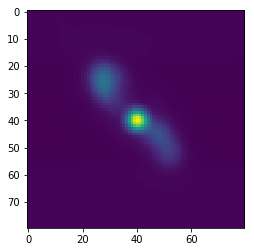

0.00141567730396
150


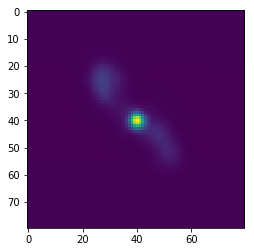

0.000365819699485
220


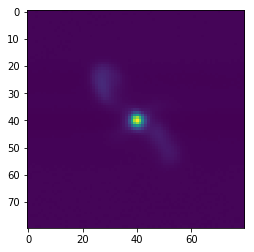

0.00402668372532


In [12]:
from matplotlib import pylab as plt
%matplotlib inline

for band in coadd_map_coadds:
    print(band)
    plt.imshow(coadd_map_coadds[band].maps['T'])#/=coadd_map_coadds[band].noise
    plt.show()
    print(np.var(coadd_map_coadds[band].maps['T'][60:,:20]))#calc_source_masked_variance(coadd_map_coadds[band].maps['T']))

In [ ]:

## Load up individual bolo maps 
    if os.path.exists(singlebolomap_loc+'%s.g3'%(obs)):
        ind_map_data = core.G3File(singlebolomap_loc+'%s.g3'%(obs))
    else:
        print('Couldnt load %s'%(singlebolomap_loc+'%s.g3'%(obs)))
        failed_obs[obs] = 'Couldnt load %s'%(singlebolomap_loc+'%s.g3'%(obs))
        continue
              

## Loop through frames and analyze individual maps
    ## if not map frame, continue
    ## if bolo not in goodbolos, continue
    log.write('Coadding Individual Bolo Maps\n')
    while True:
        try:
            fr = ind_map_data.next()
            if 'Wunpol' in fr:
                b = fr['Id']
                if b == 'map':
                    continue
                
                ## Do not include dark bolos, or resistors,or noisy bolos in coadds
                if b not in good_bolos:
                    continue
                if b not in boloprops:
                    continue
                
                band = str(int(boloprops[b].band/core.G3Units.GHz))
                if band == '-1':
                    continue

                bolo_map = CMU.CenAMap(fr)
                bolo_map.center_map(xo=xo,yo=yo)
                bolo_map.interpolate_map_nans()
                
                wafer  = boloprops[b].physical_name.split('_')[0].upper()
                nomang = np.floor(np.rad2deg(boloprops[b].pol_angle))
                bolo_map.band   = band
                bolo_map.wafer  = wafer
                bolo_map.nomang = nomang
                mapvar = bolo_map_noise[b] **2
                ## coadd single bolo maps using IV weighting
                if b not in single_bolo_coadd_maps:
                    single_bolo_coadd_maps[b] = bolo_map
                    single_bolo_coadd_maps[b].maps['T']/= np.copy(mapvar)
                    single_bolo_coadd_maps[b].noise  = np.copy(1./mapvar)
                    single_bolo_coadd_maps[b].numobs = 1
                    
                else:
                    single_bolo_coadd_maps[b].maps['T'] += np.copy(bolo_map.maps['T']/mapvar)
                    single_bolo_coadd_maps[b].noise  += np.copy(1./mapvar)
                    single_bolo_coadd_maps[b].numobs += 1
                    
                
        except StopIteration:
            break
            
        if obs not in analyzed_obs:
            np.append(analyzed_obs,obs)
            
        np.savetxt(analyzed_obs_file,np.asarray(analyzed_obs))
    log.write('Done obs %s\n'%obs)
    log.write('---------------------------\n')

    
for b in single_bolo_coadd_maps:
    single_bolo_coadd_maps[b].maps['T']/=single_bolo_coadd_maps[b].noise
    
    
with open(output_dir+'All_Obs_Single_Bolo_IVweightedCoadds.pkl', 'wb') as handle:
            pk.dump(single_bolo_coadd_maps, handle, protocol=pk.HIGHEST_PROTOCOL)

In [2]:
import sys
sys.path.append('/home/axf295/2019/code/spt3g_software/build/')
sys.path.append('/home/axf295/2019/code/spt3g_software/polcal/python/')
from spt3g import core

import CenA_Map_Utils as CMU
import General_Utils  as GU
import os
import pickle as pk
import numpy as np
from matplotlib import pylab as plt

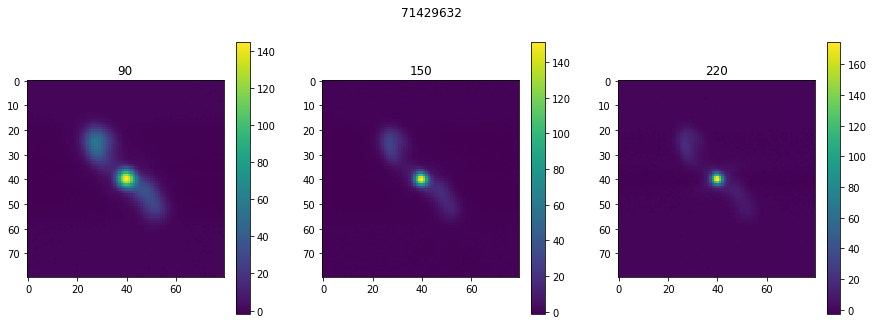

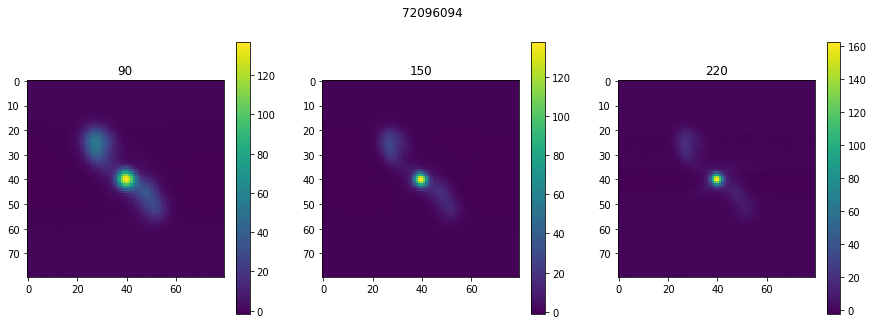

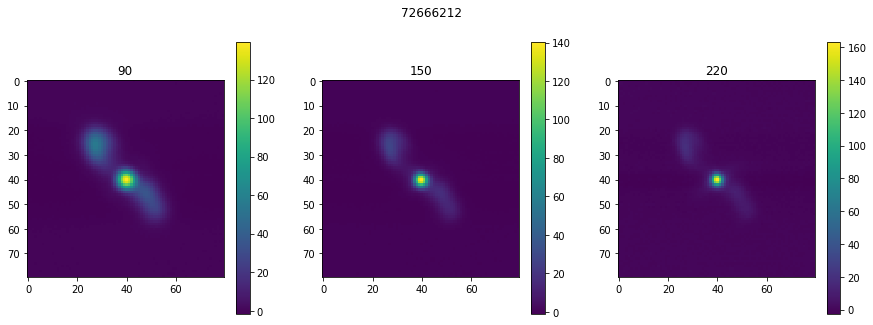

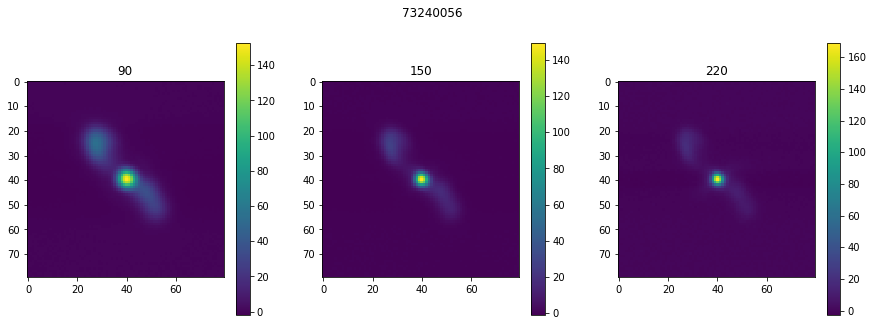

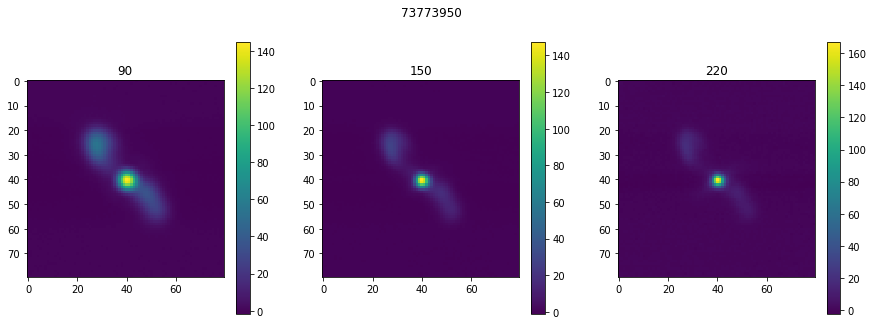

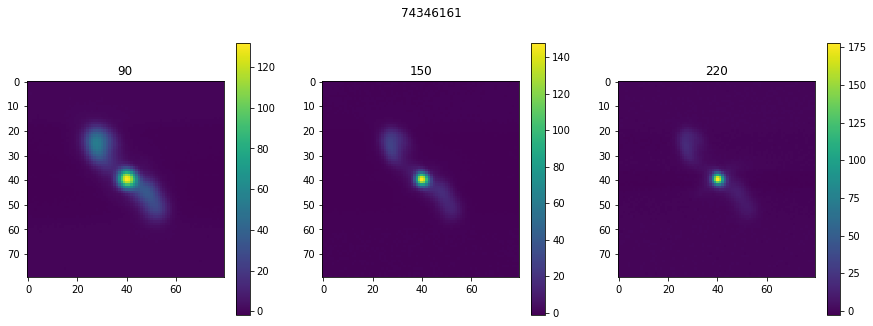

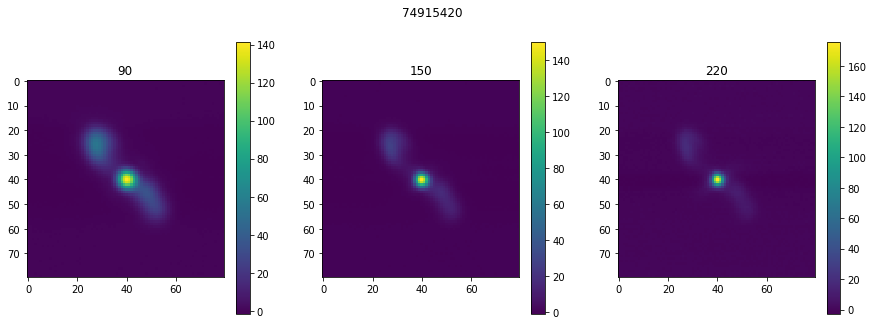

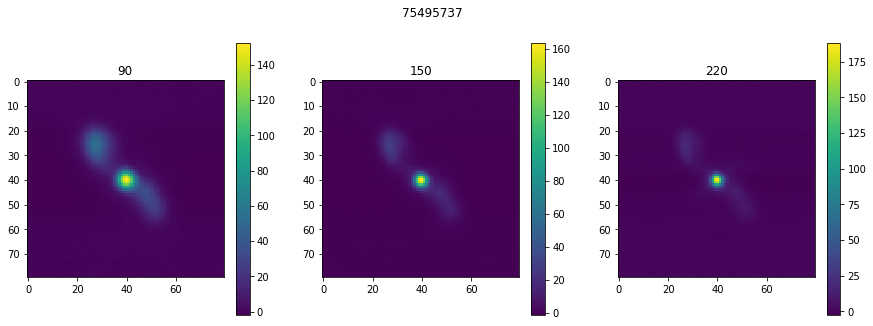

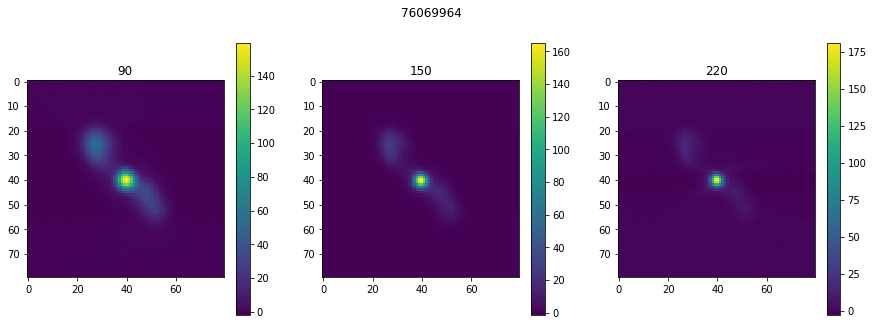

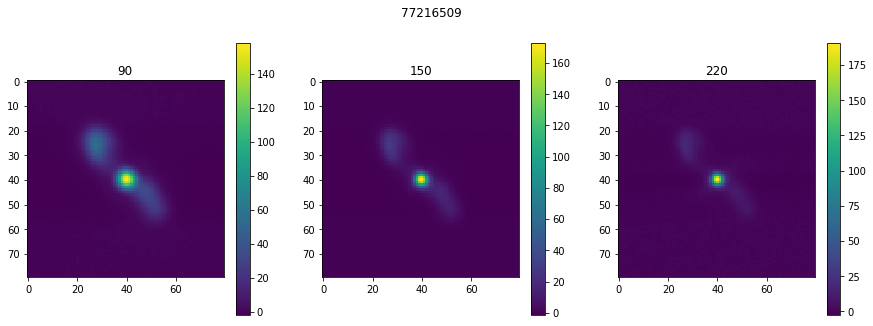

In [20]:
data_dir = '/big_scratch/axf295/2019/CenA/Analyzed_Data/'
## Load all observations
obsids = GU.get_cena_obsids(season='winter',years=[2019])

%matplotlib inline
for obs in sorted(obsids):
    try:
        coadds = pk.load(open(data_dir+'%s/%s_NomAngCoaddMaps.pkl'%(obs,obs),'rb'))
    except Exception:
        continue
    all_coadds = coadds['all']
    #print(all_coadds)
    all_angs = {}
    all_vars = {}
    for ang in all_coadds:
        
        for band in all_coadds[ang]:
            var = np.var(all_coadds[ang][band][60:,:20])
            if band not in all_angs:
                all_angs[band] = np.copy(all_coadds[ang][band]/var)
                all_vars[band] = np.copy(1./var)
            else:
                all_angs[band] += np.copy(all_coadds[ang][band]/var)
                all_vars[band] += np.copy(1./var)
    plt.figure(figsize=(15,5))
    i = 1
    for band in all_angs:
        plt.subplot(1,3,i)
        plt.imshow(all_angs[band]/all_vars[band])
        plt.colorbar()
        plt.title(band)
        i+=1
    plt.suptitle(obs)
    plt.show()

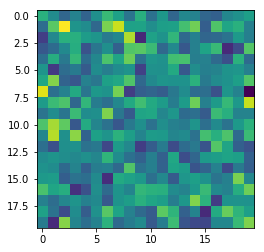

In [10]:
plt.imshow(all_coadds[ang][band][:20,60:])
